# functiong說明

save_and_open_excel 存成EXCEL 然後 打開
>save_and_open_excel(dataframe, file_name="模型相關數值.xlsx")

analyze_nan_and_zero_values 檢視空值
>analyze_nan_and_zero_values(data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False)

output_coefficients 輸出模型係數
>output_coefficients(model, poly_features, feature_names)

plot_confusion_matrix 創建混合矩陣
>plot_confusion_matrix(y_test, y_pred_lr) 

In [2]:
def save_and_open_excel(dataframe, file_name="模型相關數值.xlsx"):
    """
    將給定的 dataframe 保存到指定的 Excel 工作表中，如果工作表已存在則覆蓋，
    並嘗試在支持的應用程式中打開該 Excel 文件。

    :param dataframe: 要保存的 pandas DataFrame。
    :param file_name: Excel 文件的名稱，默認為 'vif_data.xlsx'。
    """
    import pandas as pd
    import os

    # 獲取 dataframe 的變數名稱
    frame_name = [name for name, var in globals().items() if var is dataframe][0]

    # 檢查工作表是否存在，如果不存在則創建
    if not os.path.isfile(file_name):
        with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)
    else:
        # 工作表存在，加載工作簿
        with pd.ExcelWriter(
            file_name, engine="openpyxl", mode="a", if_sheet_exists="replace"
        ) as writer:
            dataframe.to_excel(writer, sheet_name=frame_name, index=False)

    # 嘗試打開創建的 Excel 文件
    try:
        os.startfile(file_name)
    except AttributeError:
        # 如果 os.startfile() 不可用（例如在非 Windows 系統上），使用適當的替代方案
        if os.name == "posix":
            os.system(f'open "{file_name}"')
        else:
            os.system(f'start "{file_name}"')
    except Exception as e:
        print(f"打開 Excel 文件時發生錯誤: {e}")

In [3]:
"""檢視空值及零值"""

import pandas as pd


def analyze_nan_and_zero_values(
    data, threshold, sort_column="零值+NAN佔比 (%)", ascending=False
):
    """
    檢查0值和 nan 的數量
    threshold 為 百分比，例threshold=20，會回傳 零值+NAN佔比 (%) 大於20% 的
    當 threshold = 0 會回傳全部
    """

    # 如果輸入是文件路徑，讀取CSV文件並轉換成Pandas DataFrame

    if isinstance(data, str):

        file_source_pd = pd.read_csv(data)

    # 如果輸入是Pandas DataFrame，直接使用它

    elif isinstance(data, pd.DataFrame):

        file_source_pd = data

    else:

        raise ValueError(
            "Invalid input type. Input must be either file path or Pandas DataFrame."
        )

    # 計算這個範圍內每一欄的空白值(NaN)數量

    nan_values_per_column_in_range = file_source_pd.isnull().sum(axis=0)

    # 計算每個欄位的總數據量

    total_data_per_column = len(file_source_pd)

    # 計算每個欄位的空白值(NaN)佔比

    nan_percentage_per_column = (
        nan_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算這個範圍內每一欄的零值數量

    zero_values_per_column_in_range = (file_source_pd == 0).sum(axis=0)

    # 計算每個欄位的零值佔比

    zero_percentage_per_column = (
        zero_values_per_column_in_range / total_data_per_column
    ) * 100

    # 計算每個欄位的零值和NaN值的總數

    total_zero_and_nan_per_column = (
        zero_values_per_column_in_range + nan_values_per_column_in_range
    )

    # 計算每個欄位的零值和NaN值總數的佔比

    total_zero_and_nan_percentage_per_column = (
        total_zero_and_nan_per_column / total_data_per_column
    ) * 100

    # 將結果轉換為 DataFrame

    values_df = pd.DataFrame(
        {
            "欄位名稱": nan_values_per_column_in_range.index,
            "零值+NAN佔比 (%)": total_zero_and_nan_percentage_per_column.values.round(
                2
            ),
            "空白值(NaN)數量": nan_values_per_column_in_range.values,
            "空白值(NaN)佔比 (%)": nan_percentage_per_column.values.round(2),
            "零值數量": zero_values_per_column_in_range.values,
            "零值佔比 (%)": zero_percentage_per_column.values.round(2),
        }
    )

    # 將 DataFrame 存儲到 CSV 檔案中
    values_df.to_csv("零值與空白值統計.csv", index=False, encoding="utf-8-sig")

    # 如果 threshold 等於 0，則返回所有欄位
    if threshold == 0:
        return values_df

    # 篩選出 '零值+NAN佔比 (%)' 大於指定閾值的欄位

    filtered_values_df = values_df[values_df["零值+NAN佔比 (%)"] > threshold]

    # 根據指定的列進行排序

    sorted_values_df = filtered_values_df.sort_values(
        by=sort_column, ascending=ascending
    )

    return sorted_values_df


# 測試


# result_df = analyze_nan_and_zero_values(clean_data, threshold=0, sort_column='欄位名稱', ascending=False)


# print(result_df)

In [4]:
"""輸出模型係數"""

import pandas as pd
import os


def output_coefficients(model, poly_features, feature_names):
    """
    model：你的模型物件，通常是訓練好的機器學習模型，例如線性回歸模型、支持向量機模型等。

    poly_features：多項式特徵物件，這通常是一個 PolynomialFeatures 物件，用於產生多項式特徵。

    feature_names：特徵名稱列表，這是一個包含特徵名稱的字串列表，用於識別每個特徵
    """
    coef = model.coef_
    intercept = model.intercept_

    # 創建包含係數和特徵名稱的DataFrame
    coef_data = {
        "係數": [coef[i] for i in range(len(coef)) if coef[i] != 0],
        "特徵": [feature_names[i] for i in range(len(coef)) if coef[i] != 0],
    }
    coef_df = pd.DataFrame(coef_data)
    coef_df = pd.concat(
        [pd.DataFrame({"係數": [intercept], "特徵": ["截距"]}), coef_df],
        ignore_index=True,
    )

    # 創建包含特徵名稱的DataFrame
    feature_names_df = pd.DataFrame({"特徵名稱": feature_names})

    # 輸出表格
    print("係數和截距表：")
    print(coef_df)
    print("\n特徵名稱表：")
    print(feature_names_df)

    # 將 DataFrame 存入 Excel
    coef_df.to_excel("coefficients.xlsx", index=False)

    # 使用 os 模組打開 Excel 檔案
    os.system("start coefficients.xlsx")

In [5]:
"""創建混合矩陣"""

from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np  # 確保導入 numpy


def plot_confusion_matrix(y_true, y_pred, figsize=(10, 7), cmap="Blues"):
    """

    繪製混淆矩陣的熱力圖。


    參數:

    y_true -- 真實標籤

    y_pred -- 預測標籤

    figsize -- 圖形的大小 (預設為 (10, 7))

    cmap -- 熱力圖的顏色映射 (預設為 'Blues')
    """

    # 生成混淆矩陣

    cm = confusion_matrix(y_true, y_pred)

    # 轉換為比例

    cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # 使用 Seaborn 畫出混淆矩陣的熱力圖

    plt.figure(figsize=figsize)

    sns.heatmap(
        cm_ratio, annot=True, fmt=".2f", cmap=cmap
    )  # fmt='.2f' 指定顯示兩位小數

    plt.title("Confusion Matrix")

    plt.ylabel("Actual label")

    plt.xlabel("Predicted label")

    plt.show()


# 使用此函數的示例

# plot_confusion_matrix(y_test, y_pred_lr)  # 調用函數繪製混淆矩陣

# 輸入資料

In [6]:
import pandas as pd

file_path = r"..\飲料店總表0307final01_補上人氣_補值_hg.xlsx"

# dataset = pd.read_csv(file_path, sep=",", encoding="UTF-8")

dataset = pd.read_excel(file_path)
# print(dataset.info())

In [ ]:
dataset.describe().round(2)

In [ ]:
analyze_nan_and_zero_values(dataset, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

## 選擇需要的資料

In [7]:
"""selected_data
"""

selected_data = dataset[
    [
        "star",
        "school_counts",
        "drink_counts",
        "train_counts",
        "youbike_counts",
        "bus_counts",
        "park_counts",
        "night_market_counts",
        "sports_facilities_counts",
        "mrt_counts",
        "movie_theater_counts",
        "hospital_counts",
        "salary_income_median",
        "people_flow_mean",
        "knock_down_price_mean",
        "weekend_open",
        "road_area_ratio",
        "age",
        "weekday_working_hours_average",
        # "comment",
        # "people_flow_average",
        "popularity",
        # "KMEANS",
    ]
]

# selected_data

## 刪掉關係性太低的


In [ ]:
"""篩選關係姓小的"""

# 計算與 'KMEANS' 欄位相關性的系列
corr_with_kmeans = selected_data.corr()["popularity"]

# 篩選出與 'KMEANS' 相關性小於0.1的欄位
low_corr_with_kmeans = corr_with_kmeans[abs(corr_with_kmeans) < 0.1]

# 列出這些欄位的名稱
print("與 'popularity' 欄位相關性小於0.1的欄位：")
print(low_corr_with_kmeans.index.tolist())
selected_data = selected_data.drop(low_corr_with_kmeans.index.tolist(), axis=1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設的 selected_data 和 'popularity' 欄位數據
np.random.seed(0)

# 使用 pd.qcut 進行分類
Y_classification_pd = pd.DataFrame({"value": selected_data["popularity"]})
Y_classification_pd["category"] = pd.qcut(
    Y_classification_pd["value"],
    q=5,
    labels=["Category 0", "Category 1", "Category 2", "Category 3", "Category 4"],
)

# 分組並獲得統計信息
summary_df = (
    Y_classification_pd.groupby("category")["value"]
    .agg([("最小值", "min"), ("最大值", "max"), ("數量", "size")])
    .reset_index()
)

# 建立分類
value_category_ranges = [
    summary_df.loc[0, "最小值"],  # 第一類別的最小值
    summary_df.loc[1, "最小值"],  # 第二類別的最小值
    summary_df.loc[2, "最小值"],  # 第三類別的最小值
    summary_df.loc[3, "最小值"],  # 第四類別的最小值
    summary_df.loc[4, "最小值"],  # 第五類別的最小值
    summary_df.loc[4, "最大值"],  # 第五類別的最大值
]

# 使用 pd.cut 根據新的範圍劃分 'popularity' 欄位
selected_data["popularity_category"] = pd.cut(
    selected_data["popularity"],
    bins=value_category_ranges,
    right=False,  # 包括左邊界，排除右邊界
    labels=[0, 1, 2, 3, 4],
)

# 將超出範圍的值填充為最大範圍的類別（4）
selected_data["popularity_category"].fillna(4, inplace=True)

# 將 'popularity_category' 列轉換為整數類型
selected_data["popularity_category"] = selected_data["popularity_category"].astype(int)

# 打印新的分類結果和每類的數量
print(selected_data["popularity_category"].value_counts().sort_index())
print(summary_df)

In [8]:
"""因為數值分布差很多 刪掉極端"""

# 直接在原始 DataFrame 中刪除 'popularity' 小於 8726.779 的行
selected_data = selected_data[selected_data["popularity"] <= 2213.641425]
selected_data = selected_data[selected_data["popularity"] != 0]

# '''資料分布不均 取log'''
selected_data["popularity"] = np.log10(selected_data["popularity"])

# 顯示過濾後的數據
# print(selected_data)

-3.0077672625611553

In [9]:
# 使用 pd.cut 根據數值大小劃分 'popularity' 欄位
# 計算數據範圍
min_val = selected_data["popularity"].min()
max_val = selected_data["popularity"].max()

# 創建五個分組的邊界值
bins = np.linspace(min_val, max_val, 6)

# 使用 pd.cut 來分組
selected_data["popularity_category"] = pd.cut(
    selected_data["popularity"],
    bins=bins,
    include_lowest=True,  # 確保包括最低值
    labels=[0, 1, 2, 3, 4],  # 這是每個範圍的標籤
)

# 打印新的分類結果和每類的數量
# print(selected_data['popularity_category'].value_counts().sort_index())

# 建立統計信息表格
summary_df = (
    selected_data.groupby("popularity_category")["popularity"]
    .agg(最小值="min", 最大值="max", 數量="size")
    .reset_index()
)
print(summary_df)

  popularity_category       最小值       最大值    數量
0                   0 -3.007767 -1.737892    85
1                   1 -1.735366 -0.467482   265
2                   2 -0.453712  0.799761   555
3                   3  0.806709  2.072348   954
4                   4  2.073407  3.343662  2352


In [10]:
"""轉位數"""

selected_data["age"] = selected_data["age"].round(2)
selected_data["road_area_ratio"] = selected_data["road_area_ratio"].round(3)

# dataset['brand'] = dataset['brand'].fillna(-1)
# dataset['Saturday_open_hours'] = dataset['Saturday_open_hours'].fillna(-1)
# dataset['Sunday_open_hours'] = dataset['Sunday_open_hours'].fillna(-1)

# X = dataset.drop(
#     ['comment','star','people_flow_average','popularity',"KMEANS"], axis=1
# )
y = selected_data["popularity_category"]
X = selected_data.drop(["popularity", "popularity_category"], axis=1)

# y = dataset["KMEANS"]
y = y.to_frame()
print(type(y))

<class 'pandas.core.frame.DataFrame'>


### 輸入前最後一次確認參數型態

In [12]:
analyze_nan_and_zero_values(X, 0, sort_column="零值+NAN佔比 (%)", ascending=False)
# analyze_nan_and_zero_values(y, 0, sort_column="零值+NAN佔比 (%)", ascending=False)

,欄位名稱,零值+NAN佔比 (%),空白值(NaN)數量,空白值(NaN)佔比 (%),零值數量,零值佔比 (%)
0,star,0.00,0,0.0,0,0.00
1,school_counts,2.30,0,0.0,97,2.30
2,drink_counts,0.00,0,0.0,0,0.00
3,train_counts,84.45,0,0.0,3556,84.45
4,youbike_counts,10.47,0,0.0,441,10.47
5,bus_counts,1.38,0,0.0,58,1.38
6,park_counts,3.30,0,0.0,139,3.30
7,night_market_counts,54.48,0,0.0,2294,54.48
8,sports_facilities_counts,10.43,0,0.0,439,10.43
9,mrt_counts,31.18,0,0.0,1313,31.18


In [13]:
# 分割訓練和測試
from sklearn.model_selection import train_test_split

# test_size 切的尺寸 30% random_state讓抽取可以是穩定的結果(第一次抽根第十次抽是一樣的)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

# 模型

## RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 訓練隨機森林模型
randomforest_model = RandomForestClassifier(random_state=42)
randomforest_model.fit(X_train, y_train)

# 預測測試集
y_pred_rf = randomforest_model.predict(X_test)

# 計算準確率和顯示分類報告
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

print(accuracy_rf)
print(classification_report_rf)

c:\Users\student\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.694620253164557
              precision    recall  f1-score   support

           0       0.53      0.35      0.42        23
           1       0.54      0.60      0.57        72
           2       0.69      0.55      0.61       165
           3       0.49      0.30      0.37       274
           4       0.75      0.90      0.82       730

    accuracy                           0.69      1264
   macro avg       0.60      0.54      0.56      1264
weighted avg       0.67      0.69      0.67      1264



### 混淆矩陣(Confusion Matrix)

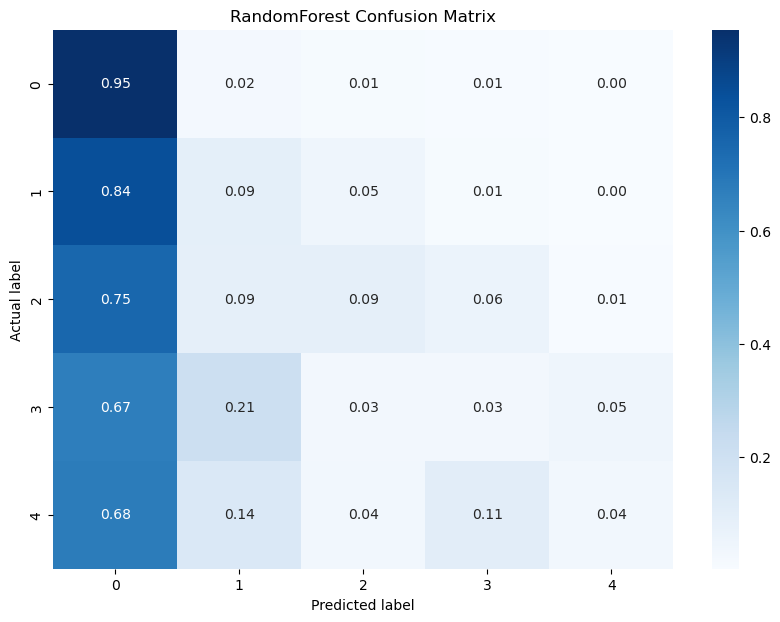

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 使用模型預測測試集
y_pred_rf = randomforest_model.predict(X_test)

# 生成混淆矩陣
cm = confusion_matrix(y_test, y_pred_rf)

# 轉換為比例
cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 使用Seaborn畫出混淆矩陣的熱力圖
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # fmt='.2f' 指定顯示兩位小數
plt.title("RandomForest Confusion Matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

### 交叉驗證(Cross-Validation)

In [15]:
# 忽略警告用的
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import cross_val_score

# 定義模型
rf_model_cv = RandomForestClassifier(n_estimators=1000, random_state=42)

# 進行5-fold交叉驗證
scores = cross_val_score(rf_model_cv, X_train, y_train, cv=5)

# 輸出每一輪的準確率以及平均準確率
print("每一輪的準確率:", scores)
print("交叉驗證結果平均準確率:", scores.mean())

每一輪的準確率: [0.65762712 0.67966102 0.66213922 0.67741935 0.64855688]
交叉驗證結果平均準確率: 0.6650807171016662


### 參數調整(Parameter Tuning)

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

# 定義參數範圍
param_grid = {
    "n_estimators": [100, 200, 400, 600],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8, 16],
    "max_features": ["auto", "sqrt", "log2"],
}

"""
'n_estimators'：您希望測試的決策樹數量。
'max_depth'：每棵決策樹的最大深度。如果為 None，則表示沒有限制。
'min_samples_split'：內部節點分裂所需的最小樣本數。
'min_samples_leaf'：葉節點所需的最小樣本數。
'max_features'：在尋找最佳分割時要考慮的特徵數量。
"""

# 定義隨機搜索的參數範圍
param_dist = {
    "n_estimators": sp_randint(100, 600),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 17),
    "max_features": ["auto", "sqrt", "log2"],
}

# 建立 RandomForestClassifier 模型
rf = RandomForestClassifier(random_state=42)

# 建立 GridSearchCV 對象
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy")

# 建立 RandomizedSearchCV 對象
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=100, cv=5, scoring="accuracy"
)

# 執行網格搜索
grid_search.fit(X_train, y_train)

# 執行隨機搜索
random_search.fit(X_train, y_train)

# 輸出結果
print("GridSearchCV 最佳參數:", grid_search.best_params_)
print("GridSearchCV 最佳交叉驗證分數:", grid_search.best_score_)
print("RandomizedSearchCV 最佳參數:", random_search.best_params_)
print("RandomizedSearchCV 最佳交叉驗證分數:", random_search.best_score_)

# 比較並輸出最好的參數
if grid_search.best_score_ > random_search.best_score_:
    print("總體最佳參數來自 GridSearchCV:", grid_search.best_params_)
    best_params = grid_search.best_params_
else:
    print("總體最佳參數來自 RandomizedSearchCV:", random_search.best_params_)
    best_params = random_search.best_params_

c:\Users\student\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\student\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\student\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\student\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\student\anaconda3\Li

GridSearchCV 最佳參數: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}
GridSearchCV 最佳交叉驗證分數: 0.682726252481943
RandomizedSearchCV 最佳參數: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 151}
RandomizedSearchCV 最佳交叉驗證分數: 0.6817098788524072
總體最佳參數來自 GridSearchCV: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}


In [17]:
# 比較並輸出最好的參數
if grid_search.best_score_ > random_search.best_score_:
    print("總體最佳參數來自 GridSearchCV:", grid_search.best_params_)
    best_params = grid_search.best_params_
else:
    print("總體最佳參數來自 RandomizedSearchCV:", random_search.best_params_)
    best_params = random_search.best_params_

總體最佳參數來自 GridSearchCV: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}


In [18]:
# best_params_str = str(best_params)
# print(f"best_params{best_params_str}")
n_estimators_value = 0
n_estimators_value = best_params["n_estimators"]  # -> 900
print(n_estimators_value)
print(type(best_params["n_estimators"]))

400
<class 'int'>


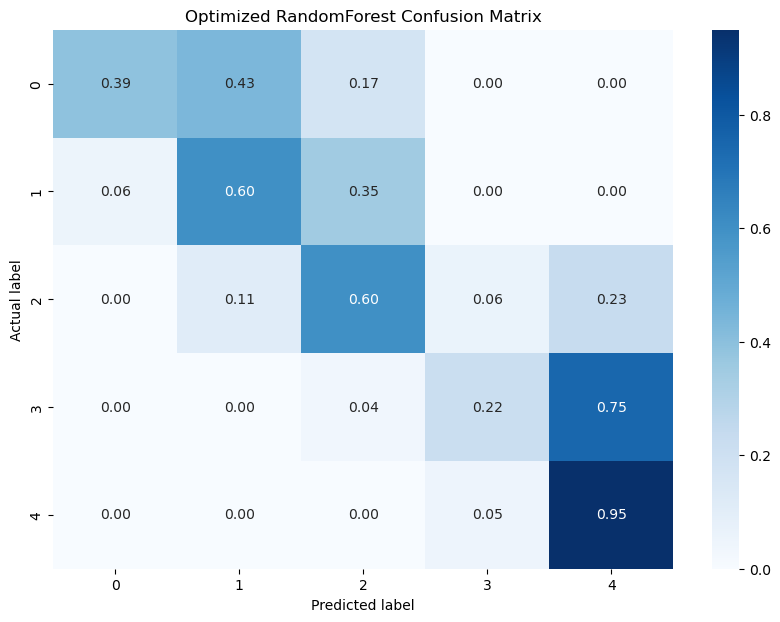

每一輪的準確率: [0.65254237 0.68135593 0.67062818 0.68251273 0.67062818]
平均準確率: 0.671533481050905


['best_randomforest_model.joblib']

In [19]:
"""用最佳參數在做一遍"""

from sklearn.ensemble import RandomForestClassifier


# 建立模型並設置參數
# 重跑要一小時(用補習班的)

best_randomforest_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    max_features="sqrt",
    min_samples_leaf=8,
    min_samples_split=2,
    random_state=42,
)


# # 建立模型並設置參數
# best_randomforest_model = RandomForestClassifier(n_estimators=n_estimators_value,
#     max_depth=best_params['max_depth'],
#     max_features=best_params['max_features'],
#     min_samples_leaf=best_params['min_samples_leaf'],
#     min_samples_split=best_params['min_samples_split'],
#     random_state=42)


# 訓練模型

best_randomforest_model.fit(X_train, y_train)


# 使用最佳模型進行預測

y_pred_best = best_randomforest_model.predict(X_test)


# 再次生成混淆矩陣並視覺化

cm_best = confusion_matrix(y_test, y_pred_best)

cm_best_ratio = cm_best.astype("float") / cm_best.sum(axis=1)[:, np.newaxis]


# 使用Seaborn畫出混淆矩陣的熱力圖

plt.figure(figsize=(10, 7))

sns.heatmap(cm_best_ratio, annot=True, fmt=".2f", cmap="Blues")

plt.title("Optimized RandomForest Confusion Matrix")

plt.ylabel("Actual label")

plt.xlabel("Predicted label")

plt.show()


"""交叉驗證"""

# 忽略警告用的

import warnings


warnings.filterwarnings("ignore", category=UserWarning)


from sklearn.model_selection import cross_val_score


# 定義模型

rf_model_cv = best_randomforest_model


# 進行5-fold交叉驗證

scores = cross_val_score(rf_model_cv, X_train, y_train, cv=5)


# 輸出每一輪的準確率以及平均準確率

print("每一輪的準確率:", scores)

print("平均準確率:", scores.mean())

"""輸出模型"""
from joblib import dump

# 保存模型
dump(best_randomforest_model, "best_randomforest_model.joblib")

### 模型係數(Coefficients)

                          Feature  Importance
14          knock_down_price_mean    0.112013
0                            star    0.110422
18  weekday_working_hours_average    0.084783
2                    drink_counts    0.078477
5                      bus_counts    0.076611
12           salary_income_median    0.067985
4                  youbike_counts    0.066567
6                     park_counts    0.060647
13               people_flow_mean    0.055347
9                      mrt_counts    0.052124
8        sports_facilities_counts    0.049442
1                   school_counts    0.043335
16                road_area_ratio    0.041822
15                   weekend_open    0.031544
17                            age    0.021680
11                hospital_counts    0.017114
10           movie_theater_counts    0.012280
7             night_market_counts    0.011466
3                    train_counts    0.006339


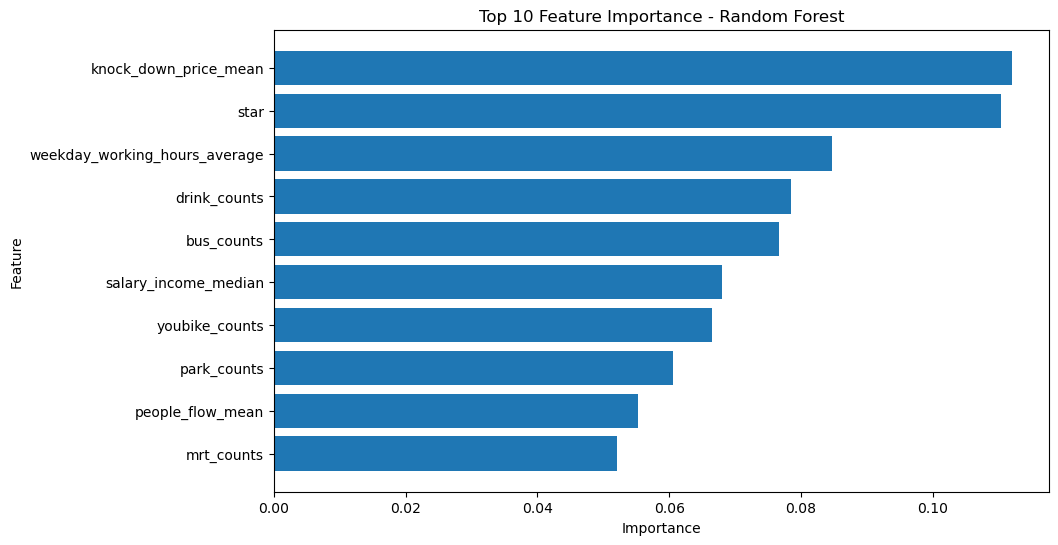

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 從隨機森林模型獲取特徵重要性
feature_names = X_train.columns
importances = randomforest_model.feature_importances_
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)


# 根據重要性進行降序排序
feature_importance_sorted = feature_importance.sort_values(
    by="Importance", ascending=False
)

# 繪製特徵重要性的水平條形圖，重要性較高的特徵會顯示在最上面
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_sorted["Feature"][:10],
    feature_importance_sorted["Importance"][:10],
)
plt.xlabel("Importance")  # 修改x軸標籤
plt.ylabel("Feature")
plt.title("Top 10 Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # 確保重要性較高的特徵顯示在最上面
plt.show()

### 將每次都記錄下來 目的是看到各參數下，最好的預測結果

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 定義參數範圍
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt", "log2"],  # 修改這裡的 max_features 設置
}

# 用於紀錄每個參數組合的混淆矩陣
confusion_matrices = {}

# 遍歷每個參數組合
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_split in param_grid["min_samples_split"]:
            for min_samples_leaf in param_grid["min_samples_leaf"]:
                for max_features in param_grid["max_features"]:
                    # 建立 RandomForestClassifier 模型
                    rf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=42,
                    )
                    # 訓練模型
                    rf.fit(X_train, y_train)
                    # 使用模型進行預測
                    y_pred = rf.predict(X_test)
                    # 計算混淆矩陣
                    cm = confusion_matrix(y_test, y_pred)
                    # 將混淆矩陣存入字典中
                    confusion_matrices[
                        (
                            n_estimators,
                            max_depth,
                            min_samples_split,
                            min_samples_leaf,
                            max_features,
                        )
                    ] = cm

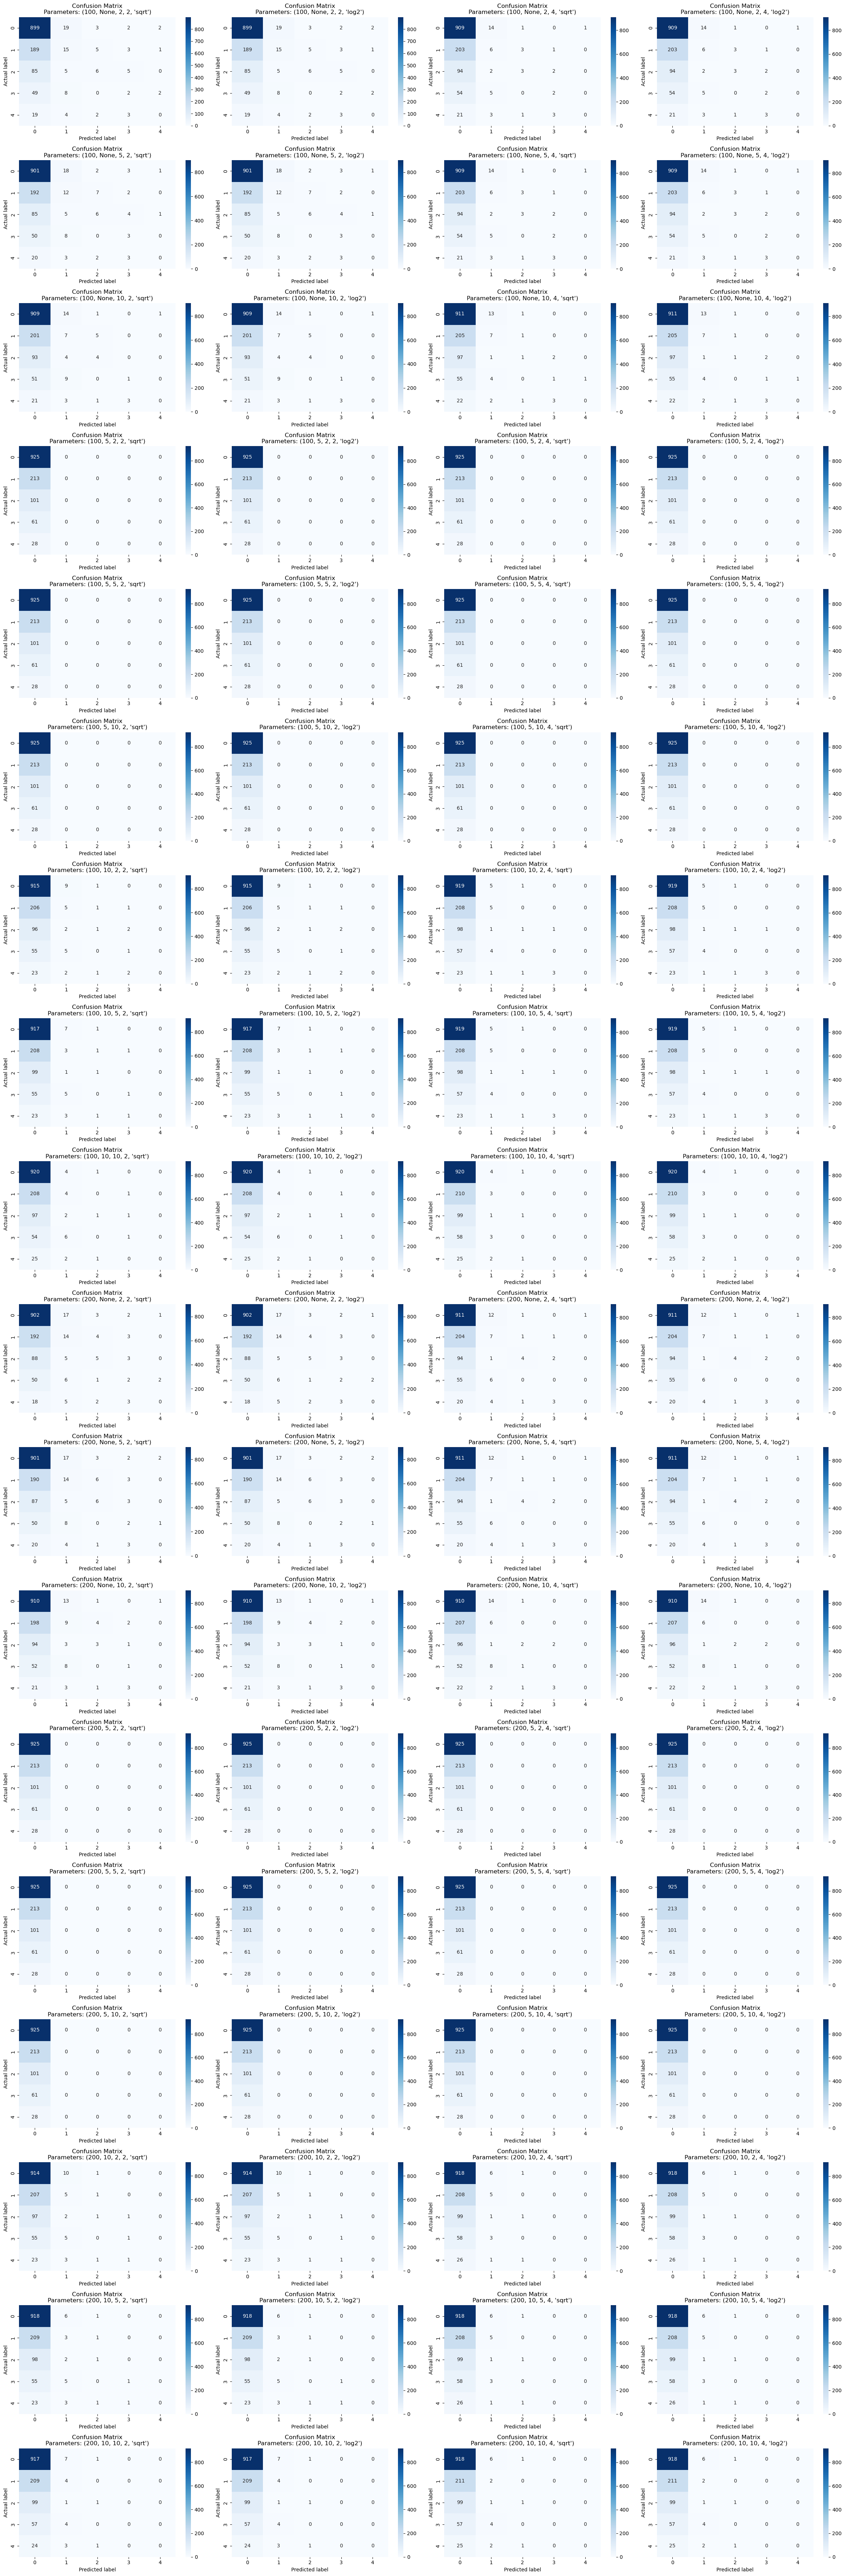

共有 72 張圖。


In [25]:
# 計算需要的列數
num_plots = len(confusion_matrices)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

# 調整大圖的大小
plt.figure(figsize=(num_cols * 6, num_rows * 4))

# 遍歷每個參數組合，並將混淆矩陣的圖加入到大圖中
for i, (params, cm) in enumerate(confusion_matrices.items(), 1):
    # 添加子圖，根據需要的行和列數
    plt.subplot(num_rows, num_cols, i)
    # 繪製混淆矩陣的圖
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix\nParameters: {params}")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")

# 調整子圖的間距
plt.tight_layout()

# 顯示大圖
plt.show()

# 輸出圖片數量
print(f"共有 {num_plots} 張圖。")

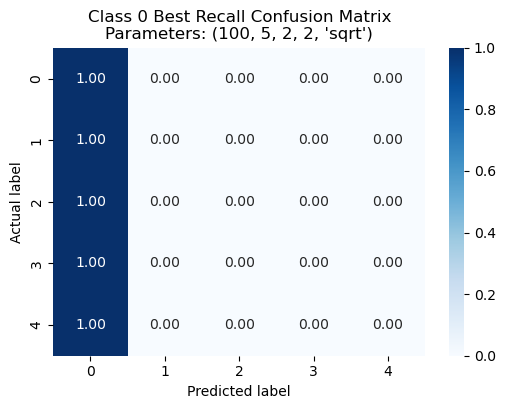

Class 0 Best Recall: Parameters - (100, 5, 2, 2, 'sqrt')


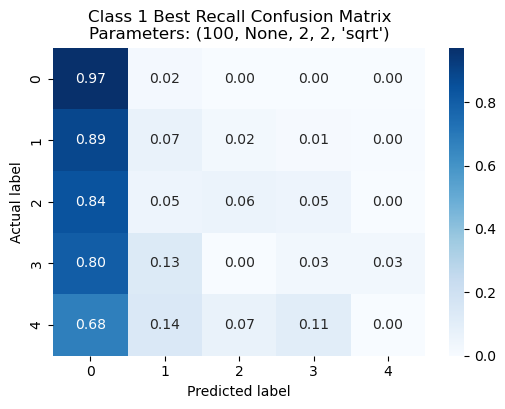

Class 1 Best Recall: Parameters - (100, None, 2, 2, 'sqrt')


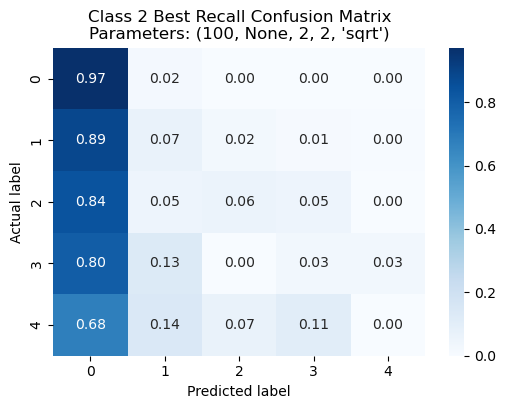

Class 2 Best Recall: Parameters - (100, None, 2, 2, 'sqrt')


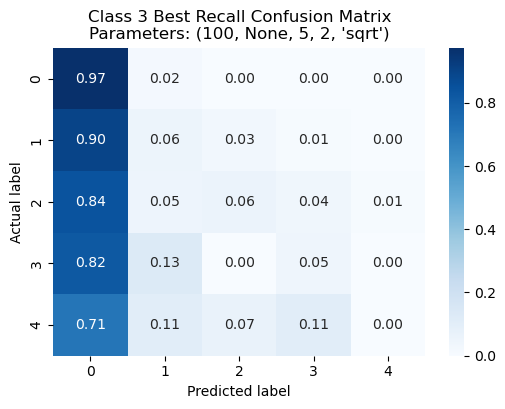

Class 3 Best Recall: Parameters - (100, None, 5, 2, 'sqrt')


AttributeError: 'NoneType' object has no attribute 'astype'

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假設 confusion_matrices 是一個字典，鍵是參數，值是對應的混淆矩陣
# 例如：confusion_matrices = {(params1): cm1, (params2): cm2, ...}

# 初始化一個字典來存儲每一類的最佳召回率和相應的參數
best_recall_matrices = {}

# 對於每一個類別
for i in range(5):  # 假設類別數量為 5
    best_recall = 0  # 存儲當前類別的最高召回率
    best_params = None  # 存儲當前最高召回率的參數
    best_matrix = None  # 存儲當前最高召回率的混淆矩陣

    # 遍歷所有混淆矩陣和它們的參數
    for params, cm in confusion_matrices.items():
        recall = cm[i, i] / cm[i, :].sum()  # 計算第 i 類的召回率
        if recall > best_recall:  # 如果找到更高的召回率
            best_recall = recall
            best_params = params
            best_matrix = cm

    # 存儲每一類的最高召回率的混淆矩陣和參數
    best_recall_matrices[i] = (best_params, best_matrix)

# 繪製每一類最高召回率的混淆矩陣和列出參數
for i, (params, cm) in best_recall_matrices.items():
    cm_ratio = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # 轉換為比例
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_ratio, annot=True, fmt=".2f", cmap="Blues")  # 使用浮點數格式
    plt.title(f"Class {i} Best Recall Confusion Matrix\nParameters: {params}")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.show()
    print(f"Class {i} Best Recall: Parameters - {params}")

https://chat.openai.com/c/5148fbf7-f239-4393-876b-aa680d7293c5